In [46]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

%matplotlib inline
sns.set_theme(style="white")

In [74]:
def itgw(L, grad_L, x_init, y_init, lr, epsilon=0.00001, max_iter = 100000): 
    """
    Implicit Twisted Gradient Descent (ITGD)

    This function implements the ITGD algorithm proposed by 
    Essid, Tabak, and Trigila (2019). This is an algorithm 
    for optimizing a min-max objective where we may expect saddle
    points. Notably, the optimization here is: 

            min_x max_y L(x, y)

    Inputs: 
        - L: the loss function, should take x and y as arguments
        - grad_L: the gradient of L, should be a vector of 2 functions that takes x and y as arguments
        - x_init: the initial value of x
        - y_init: the initial value of y
        - lr: the learning rate
        - epsilon: the stopping criterion
        - max_iter: the maximum number of iterations
    
    Outputs: 
        - x: the final value of x
        - y: the final value of y
        - x_list: a list of all x values
        - y_list: a list of all y values
    """
    # set initial values
    x = x_init
    y = y_init
    x_list = [x]
    y_list = [y]
    grad_list = [np.linalg.norm(np.array([grad_L[0](x, y), grad_L[1](x, y)]))]
    iter = 0
    # iterate until convergence
    while iter < max_iter: 
        iter += 1
        x_prev = x
        y_prev = y
        x = x_prev - lr * grad_L[0](x_prev, y_prev)
        y = y_prev + lr * grad_L[1](x_prev, y_prev)
        x_list.append(x)
        y_list.append(y)
        # check for convergence
        norm_grad = np.linalg.norm(np.array([grad_L[0](x, y), grad_L[1](x, y)]))
        grad_list.append(norm_grad)
        if norm_grad < epsilon: 
            print("Converged on iteration " + str(iter))
            break
    return x, y, np.array(x_list), np.array(y_list), np.array(grad_list)

Set up our toy example function and visualize its landscape. 

In [23]:
def toy_L(x, y): 
    return (x - 0.5) * (y - 0.5) + (1/3) * np.exp(-(x - 0.5)**2 - (y - 0.75)**2)

def toy_grad_L_x(x, y): 
    return (y - 0.5) - (2/3) * (x - 0.5) * np.exp(-(x - 0.5)**2 - (y - 0.75)**2)

def toy_grad_L_y(x, y): 
    return (x - 0.5) - (2/3) * (y - 0.75) * np.exp(-(x - 0.5)**2 - (y - 0.75)**2)

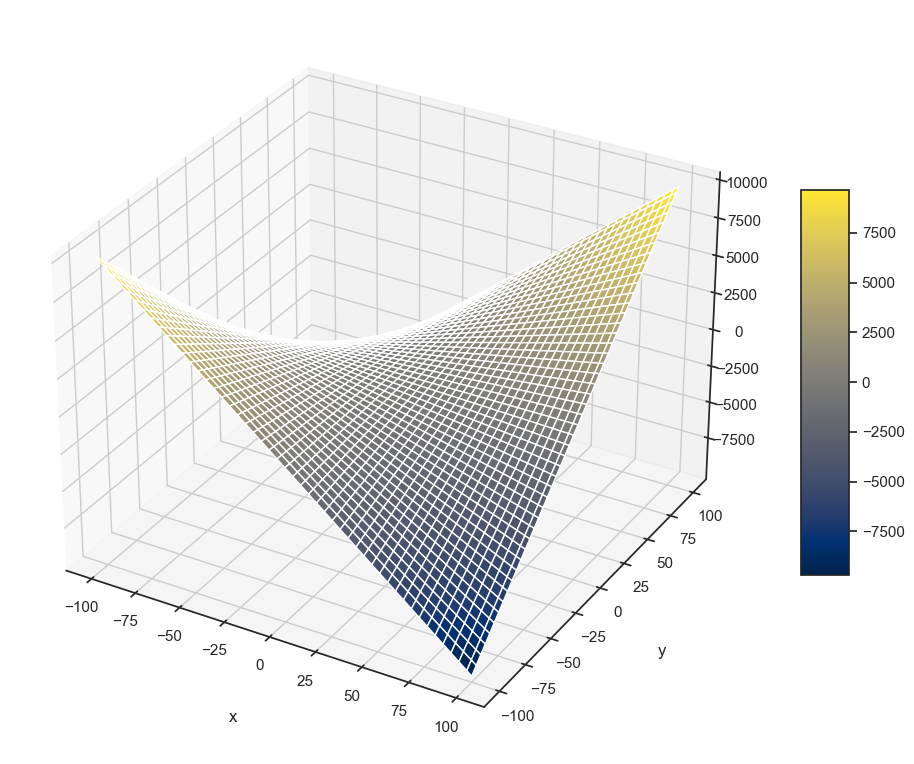

In [75]:
def plot_3D(f, x_list = None, y_list = None): 
    """
    Code adapted from Chapter 12 of "Python Programming and Numerical Methods" by Kong, Siauw, and Bayen. 
    Link: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter12.02-3D-Plotting.html
    """
    # set-up 3D plot
    fig = plt.figure(figsize = (12,10))
    ax = plt.axes(projection='3d')
    # define the domain of the function
    x = np.arange(-100, 100.1, 0.2)
    y = np.arange(-100, 100.1, 0.2)
    # generate the mesh grid for the function
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
    # visualize the function
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)
    fig.colorbar(surf, shrink=0.5, aspect=8)
    # visualize the path of the optimization algorithm if provided
    if x_list is not None and y_list is not None:
        ax.plot(x_list, y_list, zs = f(x_list, y_list), zdir = 'z', marker = 'o', color = 'r', linewidth = 3)
    plt.show()

plot_3D(toy_L)

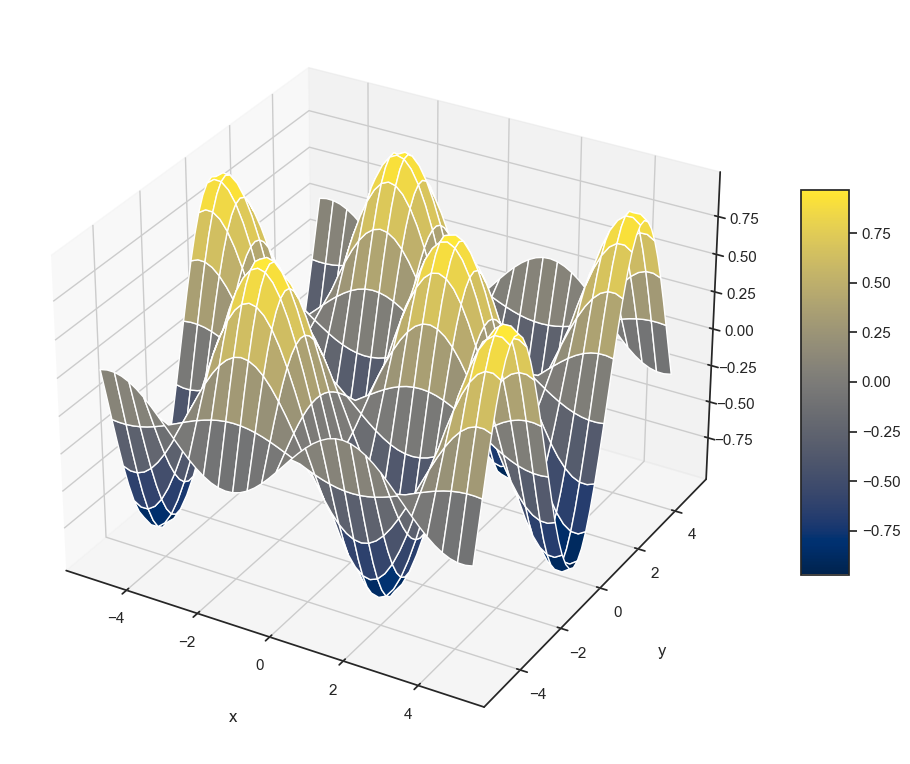

In [51]:
# visualize a non-convex function
plot_3D(lambda X, Y: np.sin(X) * np.cos(Y))

In [30]:
def vis_plot(y_list, y_axis_title = "Gradient Norm", x_axis_title = "Iteration", x_list = None): 
    """
    Produce a line plot based on the given y values. Primary use case is for visualizing the gradient norm
    over iterations of an optimization procedure, in order to determine convergence. 
    """
    if x_list is None: 
        x_list = np.arange(len(y_list))
    y_list = np.array(y_list)
    plt.plot(x_list, y_list)
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.show()

### Experiments

Checking the change in the gradient norm v.s. iteration. 

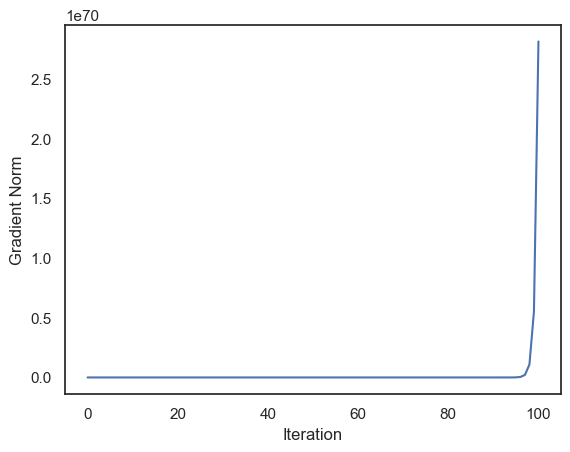

In [76]:
np.random.seed(69)
x_init = np.random.rand(1)
y_init = np.random.rand(1)
x, y, x_list, y_list, grad_list = itgw(toy_L, [toy_grad_L_x, toy_grad_L_y], x_init, y_init, 5, max_iter=100)
vis_plot(grad_list)
# result: the naive implementation of ITGD does not converge. 

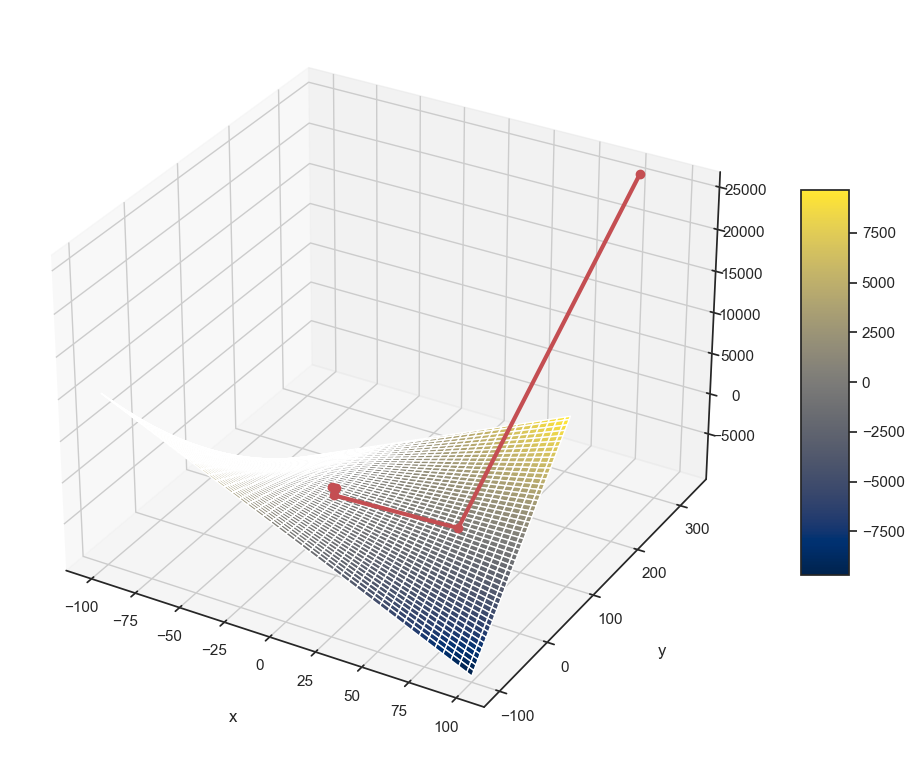

In [79]:
# quickly diverged... 
plot_3D(toy_L, x_list[:5], y_list[:5])

In [80]:
def run_trials(TRIALS, f = toy_L, grad_f = [toy_grad_L_x, toy_grad_L_y]): 
    np.random.seed(0)
    TRIALS = 100
    x_init = np.random.randint(0, 1, TRIALS)
    y_init = np.random.randint(0, 1, TRIALS)
    x_opts = []
    y_opts = []

    for trial in range(TRIALS):
        x_optim, y_optim, _, _, _ = itgw(f, grad_f, x_init[trial], y_init[trial], 0.1, epsilon=0.00001, max_iter = 1000) 
        x_opts.append(x_optim)
        y_opts.append(y_optim)
    return x_opts, y_opts

In [81]:
def visualize_optimal_points(x_values, y_values):
    """
    Visualize the distribution of optimal points found by ITGD over multiple trials.
    Inputs: 
        x_values: list of x values of optimal points
        y_values: list of y values of optimal points
    """
    grid_size = 2  # Size of the grid
    resolution = 100  # Resolution of the heatmap (higher values give smoother results)
    
    # Create a grid
    grid = np.zeros((resolution, resolution))
    x_grid = np.linspace(0, grid_size, resolution)
    y_grid = np.linspace(0, grid_size, resolution)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Compute the density of optimal points on the grid
    for x, y in zip(x_values, y_values):
        # Find the nearest grid cell
        x_index = np.argmin(np.abs(x_grid - x))
        y_index = np.argmin(np.abs(y_grid - y))
        
        # Increment the density at that grid cell
        grid[y_index, x_index] += 1
    
    # Plot the heatmap
    plt.imshow(grid, cmap='hot', origin='lower', extent=[0, grid_size, 0, grid_size])
    plt.colorbar(label='Optimal Points Density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Optimal Points Heatmap')
    plt.show()

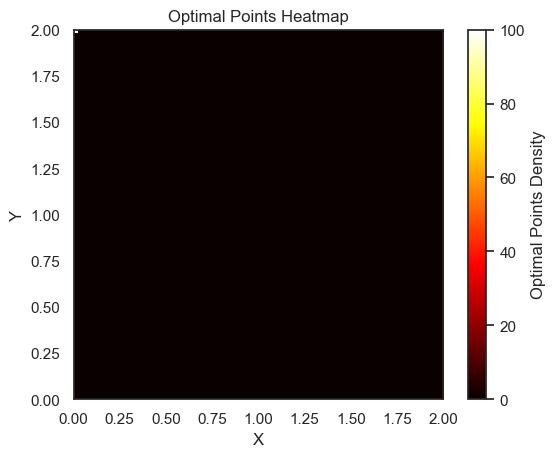

In [83]:
visualize_optimal_points(*run_trials(100))